# Processing TAHMO data
This notebook converts the .csv files downloaded using the TAHMO API to netCDF and consistent formatting. It further also processes the data by calculating mean, max and min temperatures, as well as calculating th potential evaporation of the stations. These values are then saved to netCDF which can be interpreted by the Kriging interpolation notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os.path
import pathlib
import platform 
import json 
import geopandas as gpd
import xarray as xr

## Importing the required TAHMO data

In [2]:
#Resolves the datapaths for the original writers of the code. Replace with your own correct values.

cwd = pathlib.Path().resolve()
src = cwd.parent
data = src.parent.parent.parent
OS_type = platform.system()

if OS_type == 'Darwin':
    username = 'Mats '
    data_path = os.path.join(data, 'data_tana', 'TAHMO')
    data_path_location = os.path.join(data_path, 'location_tahmo')
    
else:
    username = 'Mootje'
    data_path = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data', 'TAHMO')
    data_path_location = os.path.join(data, 'OneDrive - Delft University of Technology', 'TU Delft', 'Master ENVM', 'MDP', 'Model', 'Data')

print(f"Welcome {username}, have a wondeful day on your {OS_type} machine. Your data should be located in {data_path}")

Welcome Mats , have a wondeful day on your Darwin machine. Your data should be located in /Users/matskerver/Documents/data_tana/TAHMO


In [3]:
data_files = glob.glob(os.path.join(data_path, '*.csv'))

dataframes = {}

for file in data_files:
    station_name = os.path.splitext(os.path.basename(file))[0].split('_')[0]
    df = pd.read_csv(file, index_col = 0, sep =',', parse_dates = True)
    dataframes[station_name] = df


## Processing functions
These three functions are used to calculate the Evaporation (Oudin_evap) and Extra terrestial radiation (Extra_rad). The final function (process_dataframe) handles the dataframes and puts them in the correct formatting for use in the later stages.

In [4]:
def Oudin_evap(df, Ta, Re):
    lam = 2.45  # Latent heat of vaporization [MJ/kg]
    rho = 1000  # Water density [kg/m3]

    # Calculate potential evaporation (Pe)
    # Ensure Ta is in degrees Celsius and Re is in MJ/m2/day for the formula to work correctly
    Pe = np.where(Ta + 5 > 0, Re * (Ta + 5) / (lam * rho), 0)

    # Create a DataFrame to store the calculated Pe with the same index as Ta
    Pe_df = pd.DataFrame({'Pe': Pe}, index=Ta.index)
    
    return Pe_df


In [5]:
def Extra_rad(Tmax, Tmin, df, lat, ):
    "Calculation of Extraterrestrial radiation"
    G = 0.0820 #* 10 ** 6 # J/m^2/min  --> Constant value

    # Calculation of the radian location of the station
    phi = np.pi / 180 * lat

    # Calculation of the number of the day in a year
    J = df.index.dayofyear.values  # Extract day of the year directly from the index

    # Calculation of the extraterrestrial radiation: Ra
    dr = 1 + 0.033 * np.cos(2 * np.pi * J / 365)
    delta = 0.409 * np.sin((2 * np.pi * J / 365) - 1.39)
    w = np.arccos(- np.tan(phi) * np.tan(delta))
    Ra = ((24 * 60) / np.pi) * G * dr * (w * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(w)) #* 10 ** - 6

    # Create a DataFrame with Ra values and corresponding timestamps
    Ra_df = pd.DataFrame({'Ra': Ra}, index=df.index)

    return Ra_df

In [6]:
def process_dataframe(df):
    # Convert the index to datetime
    df.index = pd.to_datetime(df.index)
    
    # Calculate daily mean temperature
    df_temp_mean = df['te'].resample('D').mean()
    # Calculate daily minimum temperature
    df_temp_min = df['te'].resample('D').min()
    # Calculate daily maximum temperature
    df_temp_max = df['te'].resample('D').max()
    
    # Calculate daily precipitation sum
    df_pr_daily = df['pr'].resample('D').sum()
    
    # Calculate extraterrestrial radiation
    lat = -1.071545386681787  # Latitude for calculation
    df_ra = Extra_rad(df_temp_max, df_temp_min, df, lat)
    df_ra_daily = df_ra.resample('D').mean()
    # Concatenate all daily data into a single dataframe
    
    df_temp_mean = df_temp_mean.squeeze()
    df_ra_daily = df_ra_daily.squeeze()
    
    df_evap_daily = Oudin_evap(df, df_temp_mean, df_ra_daily)

    # Concatenate all daily data into a single dataframe
    df_daily = pd.concat([df_pr_daily, df_temp_mean, df_temp_max, df_temp_min, df_ra_daily, df_evap_daily], axis=1)
    
    # Rename columns
    df_daily.columns = ['pr', 'te_mean', 'te_max', 'te_min', 'ra_mean', 'evap']
    
    return df_daily


## Data cleanup

In [7]:
# Dataset from TAHMO contained three files with strange formatting, presumably due to an error with the API 
# This cell identifies the problematic datasets and prints the corresponding keys

invalid_keys = []

for key, df in dataframes.items():
    # Check if 'te' and 'pr' columns are present in the dataframe
    if 'te' not in df.columns or 'pr' not in df.columns:
        # Add the key to the list of invalid keys
        invalid_keys.append(key)

invalid_keys

['TA00360', 'TA00080', 'TA00166']

In [8]:
# Dataset from TAHMO contained three files with strange formatting, presumably due to an error with the API 
# This snipped solves the individual dataframes after manual inspection. For implementation with more stations 
# it is recommended to contact TAHMO or skip these 'faulty' stations 

if dataframes['TA00080'].shape[1] == 9: # This contains three values for each te, pr, ra, two of which are NaN
    dataframes['TA00080'].columns = ['te_1', 'te_2', 'te_3', 'pr_1', 'pr_2', 'pr_3', 'ra_1', 'ra_2', 'ra_3']
    dataframes['TA00080'] = dataframes['TA00080'].fillna(0.0)
    dataframes['TA00080']['te'] = dataframes['TA00080'].iloc[:, :3].sum(axis=1) #summed to fill the columns
    dataframes['TA00080']['pr'] = dataframes['TA00080'].iloc[:, 3:6].sum(axis=1)
    dataframes['TA00080']['ra'] = dataframes['TA00080'].iloc[:, 6:9].sum(axis=1)
    dataframes['TA00080'] = dataframes['TA00080'].iloc[:, 9:]  #Remove the faulty columns
    
if dataframes['TA00360'].shape[1] == 6: #similar to above
    dataframes['TA00360'].columns = ['te_1', 'te_2', 'pr_1', 'pr_2', 'ra_1', 'ra_2']
    dataframes['TA00360']['te'] = dataframes['TA00360'].iloc[:, :2].sum(axis=1)
    dataframes['TA00360']['pr'] = dataframes['TA00360'].iloc[:, 2:4].sum(axis=1)
    dataframes['TA00360']['ra'] = dataframes['TA00360'].iloc[:, 4:6].sum(axis=1)
    dataframes['TA00360'] = dataframes['TA00360'].iloc[:, 6:]
    
if dataframes['TA00166'].shape[1] == 9: #similar to above
    dataframes['TA00166'].columns = ['te_1', 'te_2', 'te_3', 'pr_1', 'pr_2', 'pr_3', 'ra_1', 'ra_2', 'ra_3']
    dataframes['TA00166']['te'] = dataframes['TA00166'].iloc[:, :3].sum(axis=1)
    dataframes['TA00166']['pr'] = dataframes['TA00166'].iloc[:, 3:6].sum(axis=1)
    dataframes['TA00166']['ra'] = dataframes['TA00166'].iloc[:, 6:9].sum(axis=1)
    dataframes['TA00166'] = dataframes['TA00166'].iloc[:, 9:]
    

## Processing the data
Each key in the dataframes dictionary is processd individually to obtain the required data. If desired, one can be printed to show the temperature, precipitation and radiation data on each of the stations. 

In [9]:
# Process each dataframe in the dictionary
for key, df in dataframes.items():
     # Process the dataframe and update it in the dictionary
    dataframes[key] = process_dataframe(df)

In [10]:
print(dataframes['TA00023'])

                pr    te_mean  te_max  te_min    ra_mean      evap
Timestamp                                                         
2018-03-16   3.863  22.594180    28.6    20.2  37.935921  0.427270
2018-03-17   5.423  24.084722    31.7    19.6  37.917341  0.450129
2018-03-18  12.964  23.287153    31.2    19.7  37.896801  0.437548
2018-03-19   0.017  23.143056    27.7    20.2  37.874301  0.435061
2018-03-20  29.115  22.429514    26.8    19.4  37.849847  0.423756
...            ...        ...     ...     ...        ...       ...
2023-12-27   0.000  23.702778    29.2    19.1  36.106428  0.423002
2023-12-28   0.000  24.553125    30.4    18.3  36.119712  0.435694
2023-12-29   0.000  25.063889    30.1    20.0  36.134339  0.443404
2023-12-30   0.000  25.012153    29.7    22.2  36.150293  0.442836
2023-12-31   0.000  22.400000    22.4    22.4  36.167554  0.404486

[2117 rows x 6 columns]


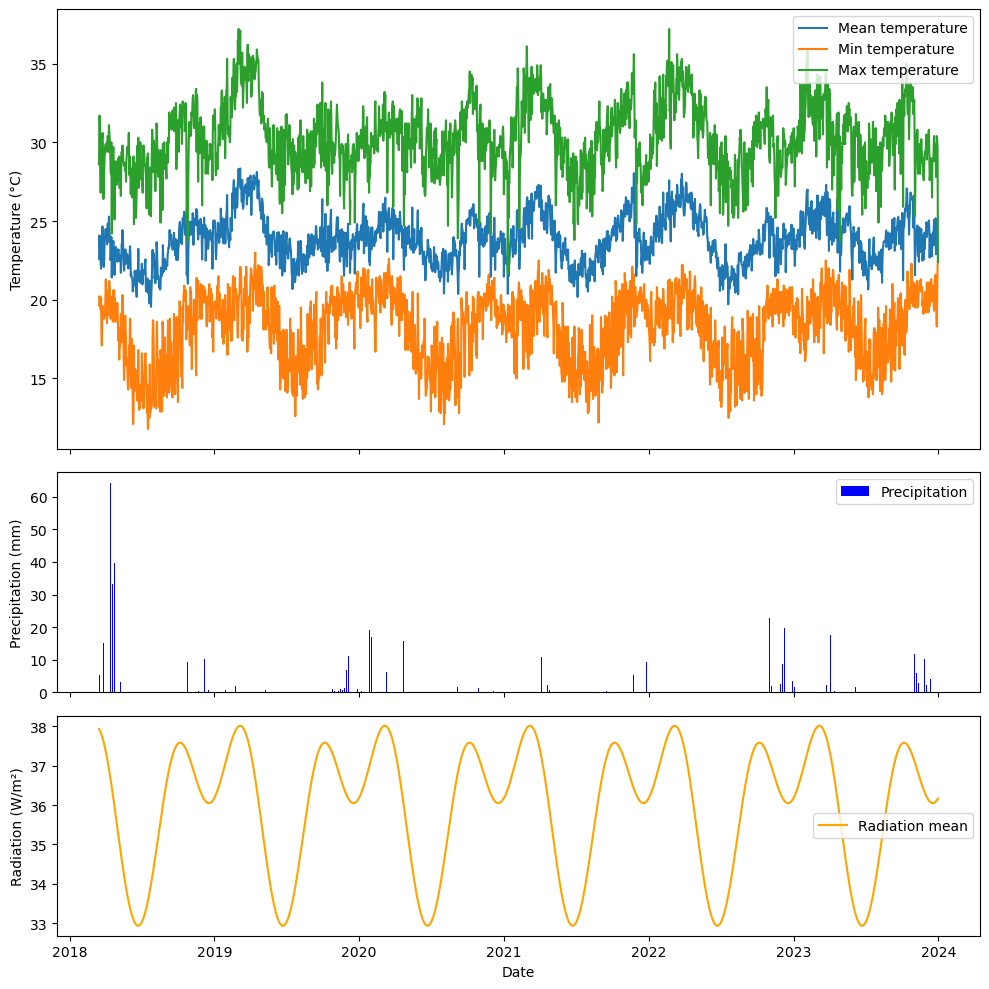

In [11]:
# If plotting_station is set to 'True' this snippet will print timeseries date of the requested TAHMO station.
plotting_station = True

if plotting_station:
    df_station = dataframes['TA00023']
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1, 1]})

    # Plot lines for mean, min, and max temperature in the first subplot
    axs[0].plot(df_station.index, df_station['te_mean'], label='Mean temperature')
    axs[0].plot(df_station.index, df_station['te_min'], label='Min temperature')
    axs[0].plot(df_station.index, df_station['te_max'], label='Max temperature')
    axs[0].set_ylabel('Temperature (°C)')
    axs[0].legend()

    # Plot a bar graph for precipitation in the second subplot
    axs[1].bar(df_station.index, df_station['pr'], width=0.4, align='center', label='Precipitation', color='blue')
    axs[1].set_ylabel('Precipitation (mm)')
    axs[1].legend()

    # Plot a line graph for radiation mean in the third subplot
    axs[2].plot(df_station.index, df_station['ra_mean'], label='Radiation mean', color='orange')
    axs[2].set_ylabel('Radiation (W/m²)')
    axs[2].legend()

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()

# adding location data back onto the dataset
First a metadata file extracted from dictionary returned by TAHMO API is opened, which is used to extract location data from the TAHMO stations. 

In [12]:
#Opens the metadata file

with open(os.path.join(data_path, 'metadata_TAHMO.txt')) as f: 
    metadata_tahmo = f.read() 
    metadata_tahmo = json.loads(metadata_tahmo) 

In [13]:
# For each station in the dataframes dictionary the location is obtained and then added to a separate dataset. 

location_name_tahmo = []
for key, value in metadata_tahmo.items():
    if key.startswith('TA'):
        location = value.get('location', {})
        name = location.get('name')
        longitude = location.get('longitude')
        latitude = location.get('latitude')
        if name and longitude is not None and latitude is not None:
            location_name_tahmo.append([key, longitude, latitude])
            

df_tahmo = pd.DataFrame(location_name_tahmo)
df_tahmo.columns = ['name', 'longitude', 'latitude']

In [14]:
# Plot the GeoDataFrame if interested 
plotting = False 
if plotting:
    geometry = [Point(lon, lat) for name, lon, lat in location_name_tahmo]
    points_df = gpd.GeoDataFrame(location_name_tahmo, columns=['name', 'longitude', 'latitude'], geometry= geometry)
    # Convert 'longitude' and 'latitude' columns to numeric values
    points_df['longitude'] = pd.to_numeric(points_df['longitude'])
    points_df['latitude'] = pd.to_numeric(points_df['latitude'])
    # Create a geometry column using longitude and latitude
    points_df['geometry'] = gpd.points_from_xy(points_df['longitude'], points_df['latitude'])
    
    points_df.plot()
    plt.title('Available TAHMO stations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

In [18]:
# This cell adds the location data back onto the dataset. If required CSV_required can be changed to True to obtain 
# individual .csv files for all stations. 

CSV_required = False

for key, value in dataframes.items():    
    match = df_tahmo.iloc[:,0].values
    #print(match)
    match_index = np.where(match == key)[0]
    dataframes[key]['longitude'] = df_tahmo.iloc[match_index[0], 1]
    dataframes[key]['latitude'] = df_tahmo.iloc[match_index[0], 2]
    if CSV_required:
        dataframes[key].to_csv(os.path.join(data_path_location, f"location_data_{key}.csv"), index=True)

## Saving data
The final dataframe is saved as an netCDF file for easy processing in other notebooks. This is done using the Python xarray package, which has a similar structure.

In [19]:
# Convert each DataFrame into an xarray DataArray and then combine them into a Dataset

data_arrays = {}
for station_id, df in dataframes.items():
    # Ensure the index name is set for conversion
    df.index.name = 'time'
    data_array = xr.DataArray(df, dims=['time', 'variable'], coords={'time': df.index, 'variable': df.columns})
    data_arrays[station_id] = data_array.to_dataset(name=station_id)

# Combine all DataArrays into a single xarray Dataset
dataset = xr.merge(data_arrays.values())
print(dataset)

# Save the dataset as a netCDF file
dataset.to_netcdf(os.path.join(data_path_location, 'NetCDF_TAHMO.nc'))

<xarray.Dataset>
Dimensions:   (time: 2191, variable: 8)
Coordinates:
  * time      (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-12-31
  * variable  (variable) object 'pr' 'te_mean' ... 'longitude' 'latitude'
Data variables: (12/31)
    TA00360   (time, variable) float64 nan nan nan nan ... 0.3543 38.0 -1.38
    TA00023   (time, variable) float64 nan nan nan nan ... 0.4045 38.04 -2.389
    TA00453   (time, variable) float64 nan nan nan nan ... 0.4443 40.03 -1.495
    TA00024   (time, variable) float64 0.02 21.23 28.8 ... 0.3587 37.05 -1.072
    TA00156   (time, variable) float64 0.0 24.49 33.1 ... 0.375 38.07 -1.701
    TA00133   (time, variable) float64 0.0 26.62 32.8 ... 0.4591 40.69 -2.298
    ...        ...
    TA00067   (time, variable) float64 nan nan nan nan nan ... nan nan nan nan
    TA00754   (time, variable) float64 nan nan nan nan ... 0.2598 37.14 -0.3884
    TA00108   (time, variable) float64 0.0 24.07 31.4 ... 0.3735 37.51 -0.9919
    TA00189   (time, variable) fl